In [274]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle

import warnings
warnings.filterwarnings('ignore')


In [275]:
with open('../data/log_dict_user.pkl','rb') as f:
    log_dict_user = pickle.load(f)
    
route_list=np.load('../data/route_list.npy', allow_pickle=True)  # 모든 루트
user_list=np.load('../data/user_list.npy',allow_pickle=True)  # 해당 루트의 유저 번호(동일 idx)


In [277]:
# load
log_data=pd.read_csv("../data/log_data.csv")
log_data=log_data.drop_duplicates()

# columns localize
log_data.columns=['유저_번호', '행동명', '행동일시', '운영체제', '앱_버전', '일_코드']

# log_data sort by time(asc)
log_data = log_data.sort_values('행동일시').reset_index(drop=True)
log_data.head()

# Datetime 변환
log_data['행동일시'] = pd.to_datetime(log_data['행동일시'])
log_data['일_코드'] = pd.to_datetime(log_data['일_코드'])

In [278]:
log_data.reset_index(drop=True, inplace=True)
len(log_data), len(log_data), len(set(log_data['유저_번호']))

(17359850, 17359850, 584636)

# 1. 경로별 인원수 세기

- // 역방향(반대방향) 행동도 추가해야할듯 나중에

In [279]:
users=list(set(log_data['유저_번호']))
route_list=[]
user_list=[]

# target의 idx들(복수)를 list로 추출
def list_idx(arr, target):
    return [i for i in range(len(arr)) if arr[i]==target]

# 유저별로 OpenApp 기준 슬라이싱
for i in tqdm(range(len(users))):
    df=log_data[log_data['유저_번호']==users[i]]
    idx_list=list_idx(list(df['행동명']), 'OpenApp')
    if len(idx_list)>0 and len(df)>0:
        for i in range(len(idx_list)):
            start=idx_list[i]
            try:
                end=idx_list[i+1]
            except:
                end=len(df)
            route_list.append(list(df['행동명'].iloc[start:end]))
            user_list.append(users[i])
        # route_list.append([df['행동명'].iloc[idx_list[i]:min(idx_list[i+1], len(df))] for i in range(len(idx_list))])
    else: continue

100%|██████████| 584636/584636 [44:28<00:00, 219.13it/s] 


In [280]:
# 프로세스 맵에 존재하는 모든 루트들
log_columns=[('OpenApp', 'SignUp'), ('OpenApp', 'Login'),
             ('SignUp', 'ViewLoanApplyIntro'), ('SignUp', 'UseLoanManage'), ('SignUp', 'UsePrepayCalc'), ('SignUp', 'UseDSRCalc'), ('SignUp', 'GetCreditInfo'), 
             ('Login', 'ViewLoanApplyIntro'), ('Login', 'UseLoanManage'), ('Login', 'UsePrepayCalc'), ('Login', 'UseDSRCalc'), ('Login', 'GetCreditInfo'),
             ('UseLoanManage', 'ViewLoanApplyIntro'), ('UsePrepayCalc', 'ViewLoanApplyIntro'), ('UseDSRCalc', 'ViewLoanApplyIntro'), ('GetCreditInfo', 'ViewLoanApplyIntro'), 
             ('ViewLoanApplyIntro', 'StartLoanApply'), ('StartLoanApply', 'CompleteIDCertification'), ('CompleteIDCertification', 'EndLoanApply')
             ]
# log_columns_str=[str(x) for x in log_columns]

In [281]:
log_pm_df = pd.DataFrame(
    [0]*len(log_columns), index=log_columns, columns=['count'])
users_noroute = []
count = 0
for i in range(len(route_list)):
    if len(route_list[i]) == 1:
        count += 1
        users_noroute.append(user_list[i])
log_pm_df.loc[''] = count

print("%d명의 유저가 경로가 없음." % (len(users_noroute)))
log_pm_df


722983명의 유저가 경로가 없음.


,count
"(OpenApp, SignUp)",0
"(OpenApp, Login)",0
"(SignUp, ViewLoanApplyIntro)",0
"(SignUp, UseLoanManage)",0
"(SignUp, UsePrepayCalc)",0
"(SignUp, UseDSRCalc)",0
"(SignUp, GetCreditInfo)",0
"(Login, ViewLoanApplyIntro)",0
"(Login, UseLoanManage)",0
"(Login, UsePrepayCalc)",0


In [282]:
# screens=['ViewLoanApplyIntro', 'UseLoanManage', 'UsePrepayCalc', 'UseDSRCalc', 'GetCreditInfo']

# 조합별 개수 count와 역색인용 Dict 함께 돌리기
for i in tqdm(range(len(route_list))):
    if len(route_list[i]) == 1:
        continue
    for n in range(0, len(route_list[i])):
        # 원소 안의 2~5개의 순서 지킨 조합에서
        # range에서도 1 빠지고 슬라이싱에서도 1 빠져서 머리 터지는 줄
        for k in range(n+1, min(n+1+5, len(route_list[i])+1)):
            # print(tuple(route_list[i][n:k]))
            # 하나일 때랑 여러개 일 때 들어가는 [] 계층이 다름
            try:
                # count
                log_pm_df.loc[[tuple(route_list[i][n:k])]] += 1
                # # dict
                # log_dict[str(tuple(route_list[i][n:k]))].append(i)
            except KeyError:
                continue
# # 역색인을 위한 dict 중복 제거
# for key in list(log_dict.keys()):
#     log_dict[key] = list(set(log_dict[key]))

log_pm_df.head()


100%|██████████| 3456728/3456728 [3:22:23<00:00, 284.65it/s]  


,count
"(OpenApp, SignUp)",12311
"(OpenApp, Login)",2131381
"(SignUp, ViewLoanApplyIntro)",5419
"(SignUp, UseLoanManage)",2959
"(SignUp, UsePrepayCalc)",0


In [283]:
log_pm_df


,count
"(OpenApp, SignUp)",12311
"(OpenApp, Login)",2131381
"(SignUp, ViewLoanApplyIntro)",5419
"(SignUp, UseLoanManage)",2959
"(SignUp, UsePrepayCalc)",0
"(SignUp, UseDSRCalc)",0
"(SignUp, GetCreditInfo)",3969
"(Login, ViewLoanApplyIntro)",296088
"(Login, UseLoanManage)",484937
"(Login, UsePrepayCalc)",4


In [284]:
log_pm_df.to_csv("../data/log_pm_df.csv", index=False)

# 2. 한도 조회 루트에서 퍼널 분석하기

In [435]:
#
LA_logs=['ViewLoanApplyIntro', 'StartLoanApply', 'CompleteIDCertification', 'EndLoanApply']

la_log_df = log_data[(log_data['행동명'] == LA_logs[1]) |
                             (log_data['행동명'] == LA_logs[2]) |
                             (log_data['행동명'] == LA_logs[3]) |
                             (log_data['행동명'] == LA_logs[0])
                             ]
la_log_df.reset_index(drop=True, inplace=True)
len(la_log_df), len(log_data), len(set(la_log_df['유저_번호']))


(7261888, 17359850, 378817)

#### funnel 용 dictionary

logs: la_log_df

url: '행동명'

unique=['ViewLoanApplyIntro', 'StartLoanApply', 'CompleteIDCertification', 'EndLoanApply']

'datetime' : '행동일시'

'session_id' : '유저_번호'

여러 일 실행한 유저는 일단 첫날로 해주긴 했는데, 다른 처리가 필요하긴 함


In [437]:
funnel_steps=pd.DataFrame(np.arange(4), index=LA_logs, columns=['step_no'])
funnel_steps

,step_no
ViewLoanApplyIntro,0
StartLoanApply,1
CompleteIDCertification,2
EndLoanApply,3


In [438]:
grouped_1=la_log_df.groupby(['유저_번호', '행동명'])['행동일시'].min()
grouped_2=la_log_df.groupby(['유저_번호', '행동명'])['행동일시'].max()
grouped_1 # 유효한 시간 내에 분석하기 위해 시간대가 가장 빠른, 늦은 이벤트 추출

유저_번호   행동명                    
11      CompleteIDCertification   2022-03-24 10:56:26
        EndLoanApply              2022-03-24 10:59:46
        StartLoanApply            2022-03-24 10:55:43
        ViewLoanApplyIntro        2022-03-24 10:55:43
12      CompleteIDCertification   2022-03-14 01:13:46
                                          ...        
879696  CompleteIDCertification   2022-03-14 05:38:16
        EndLoanApply              2022-03-14 05:42:14
        ViewLoanApplyIntro        2022-03-14 05:37:55
879698  StartLoanApply            2022-05-24 22:33:32
        ViewLoanApplyIntro        2022-05-24 22:33:32
Name: 행동일시, Length: 1297468, dtype: datetime64[ns]

In [439]:
grouped_1=pd.DataFrame(grouped_1).merge(funnel_steps, left_on='행동명', right_index=True)
grouped_2=pd.DataFrame(grouped_2).merge(funnel_steps, left_on='행동명', right_index=True)
grouped_1

,,행동일시,step_no
유저_번호,행동명,,
11,CompleteIDCertification,2022-03-24 10:56:26,2
12,CompleteIDCertification,2022-03-14 01:13:46,2
17,CompleteIDCertification,2022-03-06 10:44:49,2
19,CompleteIDCertification,2022-05-14 00:55:54,2
20,CompleteIDCertification,2022-03-14 15:38:25,2
...,...,...,...
879693,ViewLoanApplyIntro,2022-05-13 11:29:49,0
879694,ViewLoanApplyIntro,2022-03-31 20:07:23,0
879695,ViewLoanApplyIntro,2022-05-27 12:48:32,0


In [440]:
funnel_1=grouped_1.reset_index().pivot(index='유저_번호', columns='step_no', values='행동일시')
funnel_1.columns=funnel_steps.index
funnel_2=grouped_2.reset_index().pivot(index='유저_번호', columns='step_no', values='행동일시')
funnel_2.columns=funnel_steps.index
funnel_1

,ViewLoanApplyIntro,StartLoanApply,CompleteIDCertification,EndLoanApply
유저_번호,,,,
11,2022-03-24 10:55:43,2022-03-24 10:55:43,2022-03-24 10:56:26,2022-03-24 10:59:46
12,2022-03-14 01:13:22,2022-03-14 01:13:21,2022-03-14 01:13:46,2022-03-14 01:16:26
17,2022-03-06 10:44:29,2022-03-06 10:44:29,2022-03-06 10:44:49,2022-03-06 10:48:08
19,2022-05-14 00:55:30,2022-05-14 00:55:30,2022-05-14 00:55:54,2022-05-14 00:56:59
20,2022-03-14 15:37:53,2022-03-14 15:37:53,2022-03-14 15:38:25,2022-03-14 15:40:05
...,...,...,...,...
879693,2022-05-13 11:29:49,2022-05-13 11:29:49,2022-05-13 11:30:06,2022-05-13 11:34:29
879694,2022-03-31 20:07:23,2022-03-31 20:07:23,2022-03-31 20:07:42,2022-03-31 20:18:18
879695,2022-05-27 12:48:32,2022-05-27 12:48:32,2022-05-27 12:48:51,2022-05-27 12:51:23


In [441]:
# 기간이 - 인 것들 제외
for i in tqdm(range(len(funnel_1))):
    idx=funnel_1.index[i]
    if funnel_1.loc[idx][LA_logs[1]]<funnel_1.loc[idx][LA_logs[0]]:
        funnel_1.loc[idx][LA_logs[1]]=np.nan
        continue
    elif funnel_1.loc[idx][LA_logs[2]]<funnel_1.loc[idx][LA_logs[1]]:
        funnel_1.loc[idx][LA_logs[2]]=np.nan
        continue
    elif funnel_1.loc[idx][LA_logs[3]]<funnel_1.loc[idx][LA_logs[2]]:
        funnel_1.loc[idx][LA_logs[3]]=np.nan
        continue

for i in tqdm(range(len(funnel_2))):
    idx=funnel_2.index[i]
    if funnel_2.loc[idx][LA_logs[1]]<funnel_2.loc[idx][LA_logs[0]]:
        funnel_2.loc[idx][LA_logs[1]]=np.nan
        continue
    elif funnel_2.loc[idx][LA_logs[2]]<funnel_2.loc[idx][LA_logs[1]]:
        funnel_2.loc[idx][LA_logs[2]]=np.nan
        continue
    elif funnel_2.loc[idx][LA_logs[3]]<funnel_2.loc[idx][LA_logs[2]]:
        funnel_2.loc[idx][LA_logs[3]]=np.nan
        continue
funnel_1

100%|██████████| 378817/378817 [01:31<00:00, 4133.37it/s]


,ViewLoanApplyIntro,StartLoanApply,CompleteIDCertification,EndLoanApply
유저_번호,,,,
11,2022-03-24 10:55:43,2022-03-24 10:55:43,2022-03-24 10:56:26,2022-03-24 10:59:46
12,2022-03-14 01:13:22,NaT,2022-03-14 01:13:46,2022-03-14 01:16:26
17,2022-03-06 10:44:29,2022-03-06 10:44:29,2022-03-06 10:44:49,2022-03-06 10:48:08
19,2022-05-14 00:55:30,2022-05-14 00:55:30,2022-05-14 00:55:54,2022-05-14 00:56:59
20,2022-03-14 15:37:53,2022-03-14 15:37:53,2022-03-14 15:38:25,2022-03-14 15:40:05
...,...,...,...,...
879693,2022-05-13 11:29:49,2022-05-13 11:29:49,2022-05-13 11:30:06,2022-05-13 11:34:29
879694,2022-03-31 20:07:23,2022-03-31 20:07:23,2022-03-31 20:07:42,2022-03-31 20:18:18
879695,2022-05-27 12:48:32,2022-05-27 12:48:32,2022-05-27 12:48:51,2022-05-27 12:51:23


In [442]:
# NaT는 연속으로 계산
for i in tqdm(range(len(funnel_1))):
    idx=funnel_1.index[i]
    if funnel_1.loc[idx][LA_logs[0]] is pd.NaT: 
        funnel_1.loc[idx][LA_logs[1]]=pd.NaT
        funnel_1.loc[idx][LA_logs[2]]=pd.NaT
        funnel_1.loc[idx][LA_logs[3]]=pd.NaT
    elif funnel_1.loc[idx][LA_logs[1]] is pd.NaT: 
        funnel_1.loc[idx][LA_logs[2]]=pd.NaT
        funnel_1.loc[idx][LA_logs[3]]=pd.NaT
    elif funnel_1.loc[idx][LA_logs[2]] is pd.NaT:
        funnel_1.loc[idx][LA_logs[3]]=pd.NaT
        
for i in tqdm(range(len(funnel_2))):
    idx=funnel_2.index[i]
    if funnel_2.loc[idx][LA_logs[0]] is pd.NaT: 
        funnel_2.loc[idx][LA_logs[1]]=pd.NaT
        funnel_2.loc[idx][LA_logs[2]]=pd.NaT
        funnel_2.loc[idx][LA_logs[3]]=pd.NaT
    elif funnel_2.loc[idx][LA_logs[1]] is pd.NaT: 
        funnel_2.loc[idx][LA_logs[2]]=pd.NaT
        funnel_2.loc[idx][LA_logs[3]]=pd.NaT
    elif funnel_2.loc[idx][LA_logs[2]] is pd.NaT:
        funnel_2.loc[idx][LA_logs[3]]=pd.NaT

100%|██████████| 378817/378817 [01:06<00:00, 5703.75it/s]


In [443]:
# 스텝별 유저 수
step_values_1=[funnel_1[column].notnull().sum() for column in funnel_1.columns]
step_values_2=[funnel_2[column].notnull().sum() for column in funnel_2.columns]
step_values_1

[356475, 256853, 207293, 192644]

In [444]:
def funnel_data(df, a, b, default=60): # funnel = df
    time_delta_df=pd.DataFrame(df[df.columns[a]]-df[df.columns[b]])
    time_delta_df.dropna(inplace=True)
    idx_list=time_delta_df.index
    # time delta difference list (0 <= day < 1)
    for i in tqdm(range(len(idx_list))):
        idx=idx_list[i]
        if 0<=time_delta_df.loc[idx][0].days<1:
           continue
        else:
            time_delta_df.drop([idx], axis=0, inplace=True)
            
    # plt 가능한 time delta list(이상치 제거)
    plt_list = []
    count = 0
    count_range = 0
    for x in time_delta_df[0]:
        plt_list.append(x.seconds)
        if x.seconds == 0:
            count += 1
        if x.seconds <= default:  # default분을 최소 결정 기간으로 둔다.
            count_range += 1

    plt_list.sort()
    plt.plot(plt_list[count:count_range])
    plt.show()
    return time_delta_df, plt_list, count, count_range


Funnel 1 min


100%|██████████| 256853/256853 [04:12<00:00, 1019.22it/s]


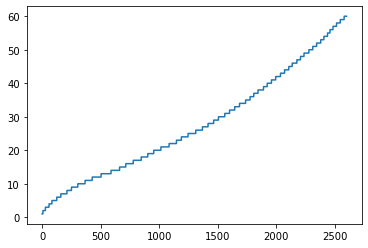

100%|██████████| 207293/207293 [01:57<00:00, 1761.24it/s]


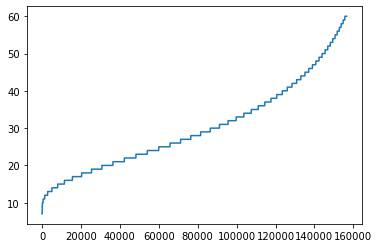

100%|██████████| 192644/192644 [01:07<00:00, 2850.54it/s]


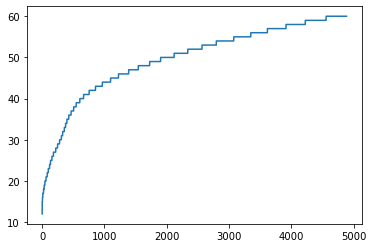

ViewLoanApplyIntro에서 StartLoanApply단계로 이동 시
누락자: 99622
총 72.053580퍼센트의 유저가 남았습니다.
걸린 평균 시간: 0.005471920874670741분
StartLoanApply에서 CompleteIDCertification단계로 이동 시
누락자: 49560
총 80.704917퍼센트의 유저가 남았습니다.
걸린 평균 시간: 12.601037947362398분
CompleteIDCertification에서 EndLoanApply단계로 이동 시
누락자: 14649
총 92.933191퍼센트의 유저가 남았습니다.
걸린 평균 시간: 0.8269797421731123분


In [445]:
# 평균 시간 계산
## 10, 32의 경우 count_range 까지를 0, 그 이후를 1로 두어 비고민/고민으로 나눈다
## 21의 경우 연속적인 형태 그대로 냅둔다.
print("Funnel 1 min")

## diff_list에는 시간 차이가, plt_list에는 초의 차이(int)가 들어있다.
time_delta_df10, plt_list10, count10, count_range10=funnel_data(funnel_1, 1, 0)
t0_1=np.mean(plt_list10[:count_range10])
time_delta_df21, plt_list21, count21, count_range21=funnel_data(funnel_1, 2, 1)
t1_2=np.mean(plt_list21[:])
time_delta_df32, plt_list32, count32, count_range32=funnel_data(funnel_1, 3, 2)
t2_3=np.mean(plt_list32[:count_range32])
mean_time=[t0_1, t1_2, t2_3]
time_delta_df_1 = step_values_1

# 스텝별 누락 비율
for i in range(1, len(funnel_1.columns)):
    print("="*20)
    print("%s에서 %s단계로 이동 시"%(funnel_1.columns[i-1], funnel_1.columns[i]))
    print("누락자: %d" % (time_delta_df_1[i-1]-time_delta_df_1[i]))
    print("총 %f퍼센트의 유저가 남았습니다." % ((time_delta_df_1[i]/time_delta_df_1[i-1])*100))
    print("걸린 평균 시간: "+str(mean_time[i-1] / 60)+"분")


Funnel 2 max


100%|██████████| 221886/221886 [00:24<00:00, 9185.07it/s] 


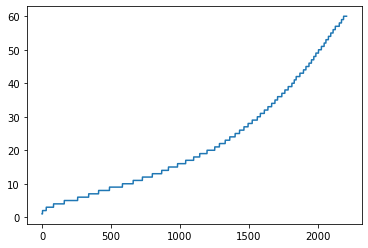

100%|██████████| 136246/136246 [00:18<00:00, 7248.05it/s]


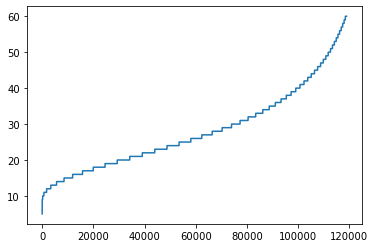

100%|██████████| 116393/116393 [00:07<00:00, 15507.71it/s]


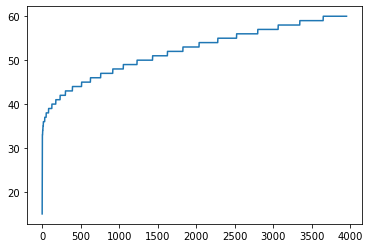

ViewLoanApplyIntro에서 StartLoanApply단계로 이동 시
누락자: 134589
총 62.244477퍼센트의 유저가 남았습니다.
걸린 평균 시간: 0.004751354865013519분
StartLoanApply에서 CompleteIDCertification단계로 이동 시
누락자: 85640
총 61.403604퍼센트의 유저가 남았습니다.
걸린 평균 시간: 3.605107207113437분
CompleteIDCertification에서 EndLoanApply단계로 이동 시
누락자: 19853
총 85.428563퍼센트의 유저가 남았습니다.
걸린 평균 시간: 0.8684702907711758분


In [446]:
# 평균 시간 계산
## 10, 32의 경우 count_range 까지를 0, 그 이후를 1로 두어 비고민/고민으로 나눈다
## 21의 경우 연속적인 형태 그대로 냅둔다.
print("Funnel 2 max")

## diff_list에는 시간 차이가, plt_list에는 초의 차이(int)가 들어있다.
time_delta_df102, plt_list102, count102, count_range102=funnel_data(funnel_2, 1, 0)
t0_1=np.mean(plt_list102[:count_range102])
time_delta_df212, plt_list212, count212, count_range212=funnel_data(funnel_2, 2, 1)
t1_2=np.mean(plt_list212[:])
time_delta_df322, plt_list322, count322, count_range322=funnel_data(funnel_2, 3, 2)
t2_3=np.mean(plt_list322[:count_range322])
mean_time=[t0_1, t1_2, t2_3]
time_delta_df_2 = step_values_2

# 스텝별 누락 비율
for i in range(1, len(funnel_2.columns)):
    print("="*20)
    print("%s에서 %s단계로 이동 시"%(funnel_2.columns[i-1], funnel_2.columns[i]))
    print("누락자: %d" % (time_delta_df_2[i-1]-time_delta_df_2[i]))
    print("총 %f퍼센트의 유저가 남았습니다." % ((time_delta_df_2[i]/time_delta_df_2[i-1])*100))
    print("걸린 평균 시간: "+str(mean_time[i-1] / 60)+"분")


# user_spec에 추가
3. 퍼널 10, 21, 32별로 고민과 비고민, 걸린 시간 추가

```python
funnel_time_cols=['funnel_10_hesitate', 'funnel_21_hesitate_sec', 'funnel_32_hesitate_sec']
```


In [447]:
time_delta_df10.describe()
# 95%인 149초까지 0, 이후 1

,0
count,233077
mean,0 days 00:12:57.494154292
std,0 days 01:47:03.124145735
min,0 days 00:00:00
25%,0 days 00:00:00
50%,0 days 00:00:00
75%,0 days 00:00:00
max,0 days 23:58:36


In [448]:
time_delta_df21.describe()
# 95%인 272초까지 채택

,0
count,195209
mean,0 days 00:12:36.062276841
std,0 days 01:41:00.113669607
min,0 days 00:00:00
25%,0 days 00:00:23
50%,0 days 00:00:32
75%,0 days 00:00:51
max,0 days 23:59:57


In [449]:
time_delta_df32.describe() 
# 95%인 494초까지 채택

,0
count,186176
mean,0 days 00:08:38.055076916
std,0 days 01:05:48.278461245
min,0 days 00:00:00
25%,0 days 00:01:52
50%,0 days 00:02:30
75%,0 days 00:03:36
max,0 days 23:59:50


In [450]:
df10_1 = [x for x in range(len(time_delta_df10)) if time_delta_df10.iloc[x][0].seconds > 149]
df10_1_list=[0]*len(time_delta_df10)
for idx in df10_1:
    df10_1_list[idx] = 1
time_delta_df10['funnel_10_hesitate']=df10_1_list

df10_12 = [x for x in range(len(time_delta_df102)) if time_delta_df102.iloc[x][0].seconds > 149]
df10_1_list2=[0]*len(time_delta_df102)
for idx in df10_12:
    df10_1_list2[idx] = 1
time_delta_df102['funnel_10_hesitate']=df10_1_list2

In [459]:
time_delta_df10.describe()

,0,funnel_10_hesitate
count,233077,233077.000000
mean,0 days 00:12:57.494154292,0.049958
std,0 days 01:47:03.124145735,0.217858
min,0 days 00:00:00,0.000000
25%,0 days 00:00:00,0.000000
50%,0 days 00:00:00,0.000000
75%,0 days 00:00:00,0.000000
max,0 days 23:58:36,1.000000


In [458]:
time_delta_df102.describe()

,0,funnel_10_hesitate
count,220755,220755.000000
mean,0 days 00:27:43.281665194,0.207107
std,0 days 01:47:24.440209414,0.405234
min,0 days 00:00:00,0.000000
25%,0 days 00:00:00,0.000000
50%,0 days 00:00:00,0.000000
75%,0 days 00:00:00,0.000000
max,0 days 23:59:19,1.000000


In [452]:
second_list=[]
for i in range(len(time_delta_df21)):
     second_list.append(time_delta_df21.iloc[i][0].seconds)
time_delta_df21['funnel_21_hesitate_sec']=second_list
for i in range(len(second_list)):
    if second_list[i] > 272:
       second_list[i]=1000 
time_delta_df21['funnel_21_hesitate_sec'] = second_list


second_list = []
for i in range(len(time_delta_df32)):
    second_list.append(time_delta_df32.iloc[i][0].seconds)
time_delta_df32['funnel_32_hesitate_sec'] = second_list
for i in range(len(second_list)):
    if second_list[i] > 494:
       second_list[i] = 1000
time_delta_df32['funnel_32_hesitate_sec'] = second_list


second_list=[]
for i in range(len(time_delta_df212)):
     second_list.append(time_delta_df212.iloc[i][0].seconds)
time_delta_df212['funnel_21_hesitate_sec']=second_list
for i in range(len(second_list)):
    if second_list[i] > 272:
       second_list[i]=1000 
time_delta_df212['funnel_21_hesitate_sec'] = second_list


second_list = []
for i in range(len(time_delta_df322)):
    second_list.append(time_delta_df322.iloc[i][0].seconds)
time_delta_df322['funnel_32_hesitate_sec'] = second_list
for i in range(len(second_list)):
    if second_list[i] > 494:
       second_list[i] = 1000
time_delta_df322['funnel_32_hesitate_sec'] = second_list



In [453]:
time_delta_df21.describe() # 75% 인 것 까지만 살리고, 나머지는 100으로

,0,funnel_21_hesitate_sec
count,195209,195209.000000
mean,0 days 00:12:36.062276841,89.732789
std,0 days 01:41:00.113669607,211.517536
min,0 days 00:00:00,0.000000
25%,0 days 00:00:23,23.000000
50%,0 days 00:00:32,32.000000
75%,0 days 00:00:51,51.000000
max,0 days 23:59:57,1000.000000


In [454]:
time_delta_df212.describe() 


,0,funnel_21_hesitate_sec
count,134506,134506.000000
mean,0 days 00:03:36.306432426,54.661733
std,0 days 00:50:18.837674791,138.655416
min,0 days 00:00:00,0.000000
25%,0 days 00:00:20,20.000000
50%,0 days 00:00:28,28.000000
75%,0 days 00:00:41,41.000000
max,0 days 23:56:14,1000.000000


In [455]:
time_delta_df32.head()

,0,funnel_32_hesitate_sec
유저_번호,,
11,0 days 00:03:20,200
17,0 days 00:03:19,199
19,0 days 00:01:05,65
20,0 days 00:01:40,100
25,0 days 00:02:38,158


In [512]:
time_delta_df10.to_csv("../data/time_delta_df10.csv")
time_delta_df21.to_csv("../data/time_delta_df21.csv")
time_delta_df32.to_csv("../data/time_delta_df32.csv")

time_delta_df102.to_csv("../data/time_delta_df102.csv")
time_delta_df212.to_csv("../data/time_delta_df212.csv")
time_delta_df322.to_csv("../data/time_delta_df322.csv")

# Funnel 1, 2 평균 때리기

In [519]:
time_delta1=pd.merge(left = time_delta_df10, right = time_delta_df102, how = "outer", on = "유저_번호")
time_delta2=pd.merge(left = time_delta_df21, right = time_delta_df212, how = "outer", on = "유저_번호")
time_delta3=pd.merge(left = time_delta_df32, right = time_delta_df322, how = "outer", on = "유저_번호")

In [520]:
time_delta1.drop(['0_y', '0_x'], axis=1, inplace=True)
time_delta2.drop(['0_y', '0_x'], axis=1, inplace=True)
time_delta3.drop(['0_y', '0_x'], axis=1, inplace=True)

In [521]:
# suffixes=('_x', '_y'), # 중복되는 변수 이름에 대해 접두사 부여 (defaults to '_x', '_y')
time_delta1['funnel_10_hesitate_mean'] = time_delta1.max(axis=1)
time_delta2['funnel_21_hesitate_sec_mean'] = time_delta2.mean(axis=1)
time_delta3['funnel_32_hesitate_sec_mean'] = time_delta3.mean(axis=1)


In [522]:
time_delta2.head()

,funnel_21_hesitate_sec_x,funnel_21_hesitate_sec_y,funnel_21_hesitate_sec_mean
유저_번호,,,
11,43.0,18.0,30.5
17,20.0,NaN,20.0
19,24.0,24.0,24.0
20,32.0,22.0,27.0
25,31.0,25.0,28.0


In [511]:
time_delta1.to_csv("../data/time_delta1.csv")
time_delta2.to_csv("../data/time_delta2.csv")
time_delta3.to_csv("../data/time_delta3.csv")
